In [61]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import imutils
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

def flatten_image(image):
    return np.array(image).flatten()

def flatten_images(images):
    return np.array([flatten_image(image) for image in images])

def read_image(class_path, image_file):
    image_path = os.path.join(class_path, image_file)
    image =  cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def apply_sobel(image):
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return [gx, gy]


image_size = 32

In [62]:
class_labels_list = []
images_list = []

data_directory = './dataset/'

#missing O
directories = os.listdir(data_directory)

for class_label, class_name in enumerate(directories):
    class_path = os.path.join(data_directory, class_name)
    for image_file in os.listdir(class_path):
        if image_file.endswith('.jpg'):
            image = read_image(class_path, image_file)
            images_list.append(image)
            class_labels_list.append(class_label)

data_x = images_list
data_y = class_labels_list

X_train, X_test, y_train, y_test = train_test_split(data_x,data_y, 
                                                    test_size=0.25, 
                                                    random_state=13)

In [63]:
x_train_sobel = [apply_sobel(image) for image in X_train]
x_test_sobel = [apply_sobel(image) for image in X_test]

print(np.array(x_train_sobel).shape)
x_test_sobel = flatten_images(x_test_sobel)
x_train_sobel = flatten_images(x_train_sobel)
print(np.array(x_train_sobel).shape)

(3312, 2, 32, 32)
(3312, 2048)


In [64]:
sobel_knn_classifier = KNeighborsClassifier(n_neighbors=5)
sobel_knn_classifier.fit(x_train_sobel, y_train)
sobel_knn_predictions = sobel_knn_classifier.predict(x_test_sobel)
sobel_knn_accuracy = accuracy_score(y_test, sobel_knn_predictions)

print("Accuracy of KNN-Sobel Classifier: ", sobel_knn_accuracy)

Accuracy of KNN-Sobel Classifier:  0.7065217391304348


In [65]:
sobel_svm_classifier = SVC(kernel='rbf', probability=True)
sobel_svm_classifier.fit(x_train_sobel, y_train)
sobel_svm_predictions = sobel_svm_classifier.predict(x_test_sobel)
sobel_svm_accuracy = accuracy_score(y_test, sobel_svm_predictions)
print("Accuracy of SVM-Sobel classifier:", sobel_svm_accuracy)

Accuracy of SVM-Sobel classifier: 0.7853260869565217


In [66]:
X_train_flatten = flatten_images(X_train)
X_test_flatten = flatten_images(X_test)

pca = PCA(n_components=64).fit(X_train_flatten)
X_train_pca = pca.transform(X_train_flatten)
X_test_pca = pca.transform(X_test_flatten)

# pca_image = X_test_pca[0].reshape((8, 8))
# plt.imshow(X_test[0], cmap='gray')
# plt.show()
# plt.imshow(pca_image, cmap='gray')

In [67]:
pca_knn_classifier = KNeighborsClassifier(n_neighbors=15) 
pca_knn_classifier.fit(X_train_pca, y_train)
pca_knn_predictions = pca_knn_classifier.predict(X_test_pca)
pca_knn_accuracy = accuracy_score(y_test, pca_knn_predictions)
print("Accuracy of KNN-PCA Classifier:", pca_knn_accuracy)

# random_sample = X_test[0]
# random_sample_prediction = pca_knn_classifier.predict(pca.transform([flatten_image(random_sample)]))
# print(f"Random Sample Prediction: {directories[random_sample_prediction[0]]}")

Accuracy of KNN-PCA Classifier: 0.7146739130434783


In [68]:
pca_svm_classifier = SVC(kernel='rbf', probability=True,C=1000)
pca_svm_classifier.fit(X_train_pca, y_train)
pca_svm_predictions = pca_svm_classifier.predict(X_test_pca)
pca_svm_accuracy = accuracy_score(y_test, pca_svm_predictions)
print("Accuracy of SVM-PCA Classifier:", pca_svm_accuracy)

Accuracy of SVM-PCA Classifier: 0.855072463768116


In [69]:
pca_knn_probabilities = pca_knn_classifier.predict_proba(X_test_pca)
pca_knn_auc = roc_auc_score(y_test, pca_knn_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for KNN-PCA classifier:", pca_knn_auc)


pca_svm_probabilities = pca_svm_classifier.predict_proba(X_test_pca)
pca_svm_auc = roc_auc_score(y_test, pca_svm_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for SVM-PCA classifier:", pca_svm_auc)

sobel_knn_probabilities = sobel_knn_classifier.predict_proba(x_test_sobel)
sobel_knn_auc = roc_auc_score(y_test, sobel_knn_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for KNN-Sobel classifier:", sobel_knn_auc)

sobel_svm_probabilities = sobel_svm_classifier.predict_proba(x_test_sobel)
sobel_svm_auc = roc_auc_score(y_test, sobel_svm_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for SVM-Sobel classifier:", sobel_svm_auc)


Area Under the Curve (AUC) for KNN-PCA classifier: 0.9818397712870608
Area Under the Curve (AUC) for SVM-PCA classifier: 0.9953626235120008
Area Under the Curve (AUC) for KNN-Sobel classifier: 0.9439131668735528
Area Under the Curve (AUC) for SVM-Sobel classifier: 0.9919820494471614


In [70]:
# X_train_combined = np.concatenate((X_train_pca, x_train_sobel), axis=1)
# X_test_combined = np.concatenate((X_test_pca, x_test_sobel), axis=1)
# merged_knn_classifier = KNeighborsClassifier(n_neighbors=5)
# merged_knn_classifier.fit(X_train_combined, y_train)
# merged_knn_predictions = merged_knn_classifier.predict(X_test_combined)
# merged_knn_accuracy = accuracy_score(y_test, merged_knn_predictions)
# print("Random KNN Combined Classifier:")
# print(f"Accuracy: {merged_knn_accuracy}")

In [73]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(pca_knn_predictions.reshape(-1, 1), y_test)

# Use the SVM classifier for predictions
svm_predictions = svm_classifier.predict(pca_knn_predictions.reshape(-1, 1))

# Calculate the accuracy of the SVM classifier
accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.2653985507246377


JfhN4MI2HfL
JEAN-MICHEL


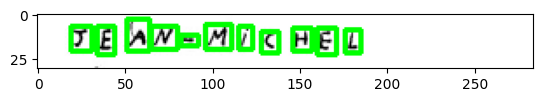

In [76]:
model = pca_svm_classifier 


def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(
        *sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse)
    )
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y : y + h, x : x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (image_size,image_size))
        thresh = pca.transform([flatten_image(thresh)])
        ypred = model.predict(thresh)
        [x] = ypred
        letters.append(x)
    return letters, image


def get_word(letter):
    word = ''
    for letter in letters:
        word += directories[letter]
    return word
    


letters, image = get_letters(
    "./misc/words/2.jpg"
)

word = get_word(letters)


import re
def transform_string(input_string):
    pattern = r'@_([A-Z])'
    
    result = re.sub(pattern, lambda match: match.group(1).lower(), input_string)
    
    result = result.replace('@_', '')
    
    return result

print(transform_string(word))
print("JEAN-MICHEL")
plt.imshow(image)